Predict Product Prices

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"

In [4]:
# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "hamzabaccouri"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

In [5]:
# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [6]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Load the dataset

In [7]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/7.07M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/991k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2137 [00:00<?, ? examples/s]

In [8]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nMinneer Racing Steering Simulator Cockpit Red with TV Bracket Mounting Holes Racing Wheel Stand/Fits Logitech G25, G27, G29/ Compatible with Xbox One, Playstation, PC Platforms with Capacity 220LBS\nPrice Guarantee#：If the price drops within 30 days of purchase, please contact us by email. We will arrange a refund of the price difference for you. Compatible with all racing wheels Thrustmaster, logitech, fanatec; fully customizable. Wide racing seat with thick padding, seat sliders and angle adjustment. Support the front and back adjustment of the seat and adjust the angle of the backrest. Compact, easy to foldable, easy to move, easy to store away. All mounting hardware and tools included. Ready to use right out the\n\nPrice is $345.00',
 'price': 344.99}

In [9]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nThe Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap\n“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when\n\nPrice is $",
 'price': 35.0}

Load our base model with 4 bit quantization and try out 1 example

In [10]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [11]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 5.6 GB


In [12]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [13]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [16]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nThe Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap\n“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when\n\nPrice is $",
 'price': 35.0}

In [14]:
model_predict(test[0]['text'])

7.5

Trying out our base Llama 3.1 model against the Test dataset

In [17]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $7.50 Truth: $35.00 Error: $27.50 SLE: 2.08 Item: The Phantom of the O...
2: Guess: $7.00 Truth: $135.99 Error: $128.99 SLE: 8.07 Item: Norcold 628970 Fridg...
3: Guess: $299.00 Truth: $178.43 Error: $120.57 SLE: 0.26 Item: SPT Compact Refriger...
4: Guess: $1.00 Truth: $6.98 Error: $5.98 SLE: 1.91 Item: Letter Red B Inch Si...
5: Guess: $19.99 Truth: $45.99 Error: $26.00 SLE: 0.65 Item: Konami Classics Arca...
6: Guess: $25.00 Truth: $88.99 Error: $63.99 SLE: 1.54 Item: Mini Washing Machine...
7: Guess: $19.99 Truth: $104.95 Error: $84.96 SLE: 2.62 Item: Farmhouse Buffalo Pl...
8: Guess: $19.99 Truth: $215.00 Error: $195.01 SLE: 5.43 Item: Corpse Party Back to...
9: Guess: $25.00 Truth: $75.00 Error: $50.00 SLE: 1.15 Item: True leather case fo...
10: Guess: $1.00 Truth: $97.71 Error: $96.71 SLE: 15.20 Item: Virtua Cop 2 Japan I...
11: Guess: $25.00 Truth: $57.00 Error: $32.00 SLE: 0.64 Item: Covogoods CovoBox v2...
12: Guess: $25.00 Truth: $58.49 Error: $33.49 SLE: 0.69 Item

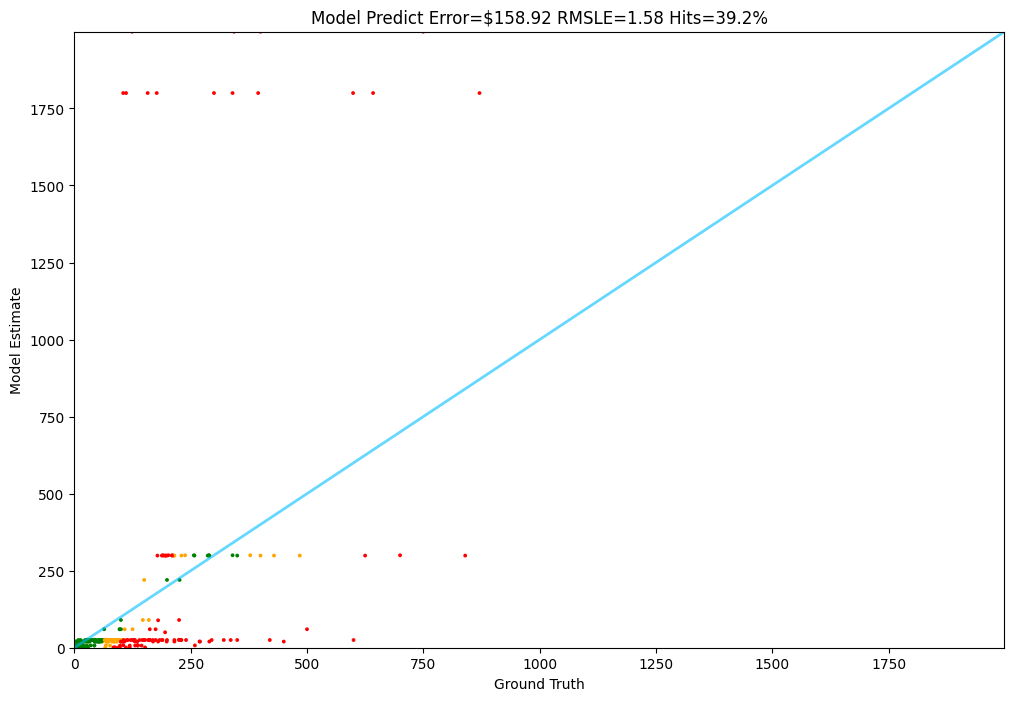

In [18]:
Tester.test(model_predict, test)